In [2]:
import matplotlib
#matplotlib.use('Agg')
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter

# Para manejar los archivos y automatizar la lectura en directorios
import csv
import os

# Fontsize
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
# Latex font
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Nombres de archivo, paths y definiciones

In [3]:
# SOME DEFINITIONS
# Level of the simulation ('_' for filename format)
lvl = 'Level 4/level4_'
# number of halos
nhalos = 30 

'''# level of the simulation
lvl = 'Level 3/level3_'
# number of halos
nhalos = 6''' 

# FOLDER CONTAINING ALL FILES
folder = '../Data/Halo_General/'

# FILENAMES
# Triaxial eigensystem different radii (MHD & DM) using volumetric (mean) density: Allgood et al.
fn_axes = lvl+'axes'+'.csv' # Axes = axial ratios (sqrt of eigenvals)
# Triaxial system approximation with Isopotential contours
fn_axes_pot = lvl+'potential_axes'+'.csv'
# Triaxial system approximation with Isodensity contours
fn_axes_den = lvl+'density_axes'+'.csv'

# Contains parameters of the disk (MHD)
fn_params = lvl+'params'+'.csv'
# Triaxial eigensystem different radii (MHD & DM) using volumetric (mean) density: Allgood et al.
fn_axes = lvl+'axes'+'.csv' # Axes = axial ratios (sqrt of eigenvals)
fn_vecs = lvl+'vecs'+'.csv' # Vecs = principal axes directions



# Reads file in "path/filename"
# Returns data as a numpy array
# Returns filenames as a list of strings
# Returns headers as an array of strings

def read_csv(filename,skip_header=1):

    # Removes quotations from file (little writing error) 
    os.system('sed -i \'s/"//g\' '+filename) 
    
    # FILENAMES!
    headers = []
    with open( filename , 'r') as myfile:
        rd = csv.reader(myfile)
        headers = next(rd) # gets only first line 
    
    data = np.genfromtxt(filename, delimiter = ',', skip_header=skip_header, dtype=float )
    
    return headers,data

# Obteniendo los datos

In [4]:
# Obtiene el contenido del archivo de semiejes
headers,axes = read_csv(folder+fn_axes)
print(headers)
# Obtiene el contenido del archivo de vctores propios asociados
headers,vecs = read_csv(folder+fn_vecs)
# Archivo de informacion de materia de las galaxias

##############
# Parameters #
##############
# Parameter names, parameters associated to MHD galaxies
params_nms,params = read_csv(folder+fn_params)
# skip the first row of parameters (haloname)
params = params.T[1:].T
params_nms = params_nms[1:]

# Dictionary of parameters
par = dict(zip(params_nms,params.T))

# Column fields are:
#'SFR', 'DiskRad', 'MassGas', 'MassDM', 'MassStars', 'MassBH', 'HaloRadCrit500', 'vDisk1', 'vDisk2', 'vDisk3'

# Important quantities (normalized)
GasDiskRad = par['GasDiskRad']               # halfmass radius of gas
StarDiskRad = par['StellarDiskRad']          # Same for stellar mass     
gas_den = par['MassGas']#/(GasDiskRad**2)     # Mass densities
star_den = par['MassStars']#/(StarDiskRad**2)
BH_den = par['MassBH']#/(StarDiskRad**2)
bar_frac = (par['MassGas']+par['MassStars'])/(par['MassDM']+par['MassGas']+par['MassStars']) # The baryonic fraction


['a12', 'b12', 'c12', 'a25', 'b25', 'c25', 'a50', 'b50', 'c50', 'a1', 'b1', 'c1', 'aDisk', 'bDisk', 'cDisk']


### Formato de archivo
\n
<font size=3>
En el archivo de semiejes, la primera letra es el semieje correspondiente $a>b>c$
Los caracteres consecutivos indican el radio en el que fue caracterizada la forma:
</font>

*  $12 \equiv 12.5\%\ R_{vir}$ 
*  $25 \equiv 25\%\ R_{vir}$ 
*  $50 \equiv 50\%\ R_{vir}$ 
*  $Disk \equiv Sampleado\ en\ el\ disco\ estelar$ 

\
<font size=3>
Adicionalmente, en terminos de filas, el archivo muestra los ejes de los halos MHD y DM intercalados de la siguiente manera:
</font>

*  --------Header------------
*  ----Info Halo1 MHD----
*  ----Info Halo1  DM------
*  ----Info Halo2 MHD----
*  ----Info Halo2  DM------
*        -------------...--------------

\

<font size=3>
Para el archivo de vectores de ejes principales el formato sigue la misma logica
</font>


In [5]:
# Dado el formato del archivo explicado anteriormente
# Se obtienen los resultados en terminos de arrays

# RADII SAMPLED
rad_sampl = ['12.5%Rvir'
            ,'25%Rvir'
            ,'50%Rvir'
            ,'100%Rvir'
            ,'Stellar Disk']

# AXES
axes = np.reshape(axes,(2*nhalos,5,3)) # contains DM and MHD (2*nhalos) axes (3) sampled at (5) radii
axesMHD = axes[::2] #organized halo1MHD,halo1DM,halo2MHD,halo2DM....
axesDM = axes[1::2]

# indices > haloid, rad_sampled, axis id

# VECS
vecs = np.reshape(vecs,(2*nhalos,5,3,3)) # contains DM and MHD (2*nhalos) vecs (3,3) sampled at (5) radii
vecsMHD = vecs[::2]
vecsDM = vecs[1::2]

# indices > haloid, rad_sample

# Data Analysis
## Definition of sphericity-asphericity

Given the visual representation of an ellipsoid shape in the Triaxiality plane (**q** Vs **s**), where the sphere is represented by the point (1,1), we can define the ashpericity (or sphericity) as the distance between the point definining the ellipsoid shape (q,s) and that point (1,1). Then The Asphericity would be given by:

$$ Asph1 = \sqrt{(1-q)^2 + (1-s)^2} $$

And in an simmilar way, the Sphericity:

$$ Sph1 = 1-\sqrt{\frac{(1-q)^2 + (1-s)^2}{2}} $$

given that the maximum distance in this plane would be \sqrt(2)


In [6]:
# Calculates a measure of asphericity
# Returns the 1 minus actual distance from the point in the plane (c/a,b/a) to the point (1,1) in the triaxiality plane
# Sphericity is 1 if object is a sphere and bigger than 0 if axial ratios are different from 1
def sphericity1(axes):
    return 1-(1./np.sqrt(2))*np.sqrt((1-(axes[:,:,1]/axes[:,:,0]))**2 + (1-(axes[:,:,2]/axes[:,:,0]))**2)    

## The problem: Data preparation
We use  Machine learning to understand the principal variables that linearly(or not) affect the change in shape between DM and MHD simulations. Specificacally, we want to validate if the change in shape from DM to MHD simulations is a simple function of the galaxy characteristics like those in params. We work at the Disk regime where the effect of gas would be maximum.

The target variable in this case would be some kind of difference in the sphericities between DM and MHD, being the fit variables the parameters of the MHD simulation, that would be the principal causes for the shape modification.

For this reason we try two metrics. A metric for an additive model:

$y1 = Sph_{MHD} - Sph_{DM} $

And a metric for a multiplicative model:

$y2 = log{(Sph_{MHD})} - log({Sph_{DM}}) $

Note that the use of Sphericity or Asphericity quantities is irrelevant in this treatment.

## Feature treatment 
Each feature is numeric and is transformed with a translation to the mean and a normalization by the standard deviation so that each variable is equally weighted in multilinear models and scale does not represent an important bias.






In [7]:
# Defines Sphericity
sph_MHD = sphericity1(axesMHD) #shape: (nhalos,5)
sph_DM  = sphericity1(axesDM)

#################### The predictive features ####################

# In case the change in sphericity is related to the unperturbed state of the halo
x1 = axesDM[:,0,1]/axesDM[:,0,0] #b/a DM (q)
x2 = axesDM[:,0,2]/axesDM[:,0,0] #c/a DM (s)
x1 = 1./x1
x2 = 1./x2
# The predictive features
X = np.array([GasDiskRad,StarDiskRad,np.log10(gas_den),np.log10(star_den),np.log10(BH_den),bar_frac]).T#,x1,x2]).T
# Variables to logarithmic scale
Xlog = [0,0,1,1,1,0,0,0,0]
# Names oof variables
Xnames = ['Gas Radius','StarDisk Radius','Gas density','Star density','BH density',
                'Baryonic fraction']#,'q','s']

################### Variable normalization ##############

# Mean values
meanX = np.mean(X, axis = 0)
# STD but with the signs of the coeficients
sigmaX = np.std(X, axis = 0)

X = ((X-meanX)/sigmaX)

## Target selection
The triaxial properties of the haloes are sampled at 5 different radii. As 5 studies probably wont have the expected relevance, we are must choose at which radii the expected effect would be representative.

The criterium for the radii to be representative of the expected effect is that this effect would be maximum. In this case, the expected effect is the difference in asphericity and therefore we will choose the radius at which this difference has the maximum mean over all means, taking this mean over all haloes.

In [8]:
# The difference in asphericity sampled at each radius
delta_sph = (sph_MHD - sph_DM)
# The mean in this difference across all haloes for each radius
delta_sph_mean = np.mean(delta_sph, axis = 0)
# The index order 
indices = np.argsort(-delta_sph_mean)
maxindex = indices[0]
print(delta_sph_mean,indices,maxindex)

##################### The Target variables ######################

# That maximize the effect we are trying to predict

# Additive metric 
y1 = (sph_MHD - sph_DM)[:,maxindex] # 0 -> only calculated at RDisk
# Multiplicative metric 
y1 = np.log(sph_MHD/sph_DM)[:,maxindex] # 0 -> only calculated at RDisk


#################### Outliers #########################
# We can manually eliminate outliers from our fit
# Halos to discard
#i_discard = np.where(y<0.1)[0]
#i_discard = [10]
#badX = X[i_discard]
#bady = y1[i_discard]
#X = np.delete(X,i_discard,axis=0)
#y1 = np.delete(y1,i_discard)

#print(y1)


###########################################
#### Bootstrapping 
###########################################
# Choose indices with repllacement
train_index = np.random.choice(len(y1), 3*len(y1), replace = True)
X_boots = X[train_index]
y_boots = y1[train_index]


[ 0.26153017  0.22840709  0.19679957  0.15998861  0.18772534] [0 1 2 4 3] 0


## LASSO fit

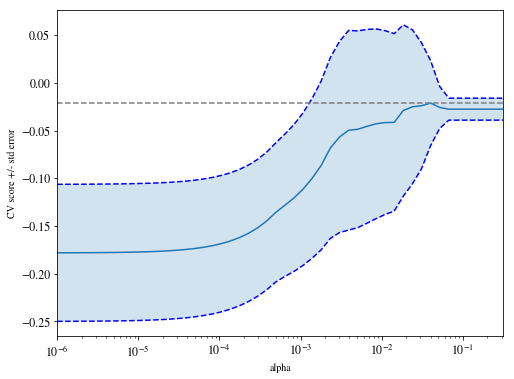

Optimal alpha is :{0} 0.03999823395608933


In [9]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV


# Lasso

# we select the best multilinear model 
# varying the parameter alpha 

# LASSO initialize 
lasso = Lasso(random_state=2305, max_iter=10000)

# The alphas to search. In this case it is the only parameter
alphas = np.logspace(-6, -0.5, 50)
tuned_parameters = [{'alpha': alphas}]


# Folds for cross validation
n_folds = 3

# Grid search for lasso
clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X_boots, y_boots)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

####################################
## Results parameter tunning graphs
####################################
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

plt.show()

alpha_optimal = alphas[np.argmax(scores)]
print("Optimal alpha is :{0}",format(alphas[np.argmax(scores)]))


## LASSO alpha tunning
According to this cross validation exploration the optimal alpha is 0.0142252931349, however, we are to verify this with LASSOCV, that chooses its optimal alpha automatically. If these two methods of tunning are not consistent, it may be because of the small sample of data we work with


In [10]:
from sklearn.model_selection import KFold

## LASSO CV with same parameters as before
lasso_cv = LassoCV(alphas=alphas, cv=n_folds, random_state=2305, max_iter=10000)
k_fold = KFold(4)

for k, (train, test) in enumerate(k_fold.split(X_boots, y_boots)):
    lasso_cv.fit(X_boots[train], y_boots[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X_boots[test], y_boots[test])))



[fold 0] alpha: 0.01842, score: 0.05380
[fold 1] alpha: 0.01842, score: 0.10364
[fold 2] alpha: 0.03089, score: 0.07343
[fold 3] alpha: 0.00848, score: -0.00110


### Optimal alpha is indeed around  0.01


### LASSO results

Gas Radius


Slope 0.0138214845748
Feature correlation 0.334503445634 



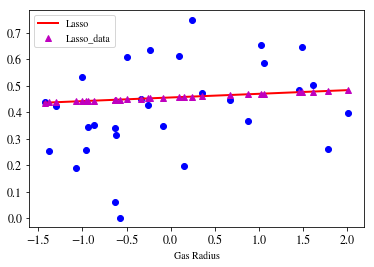

StarDisk Radius


Slope -0.0
Feature correlation -0.244235641068 



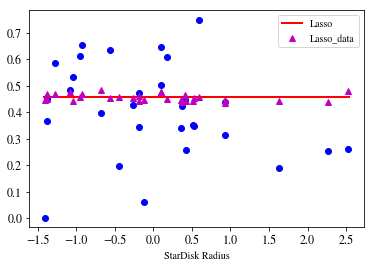

Gas density


Slope 0.0
Feature correlation 0.180291202987 



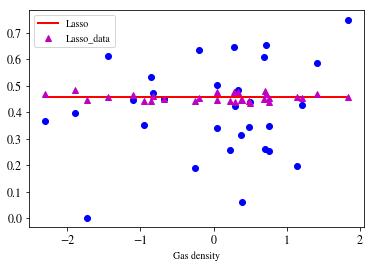

Star density


Slope 0.0
Feature correlation 0.139209545181 



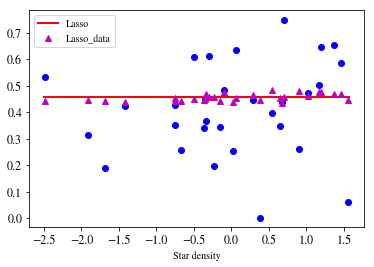

BH density


Slope 0.0
Feature correlation 0.19111421441 



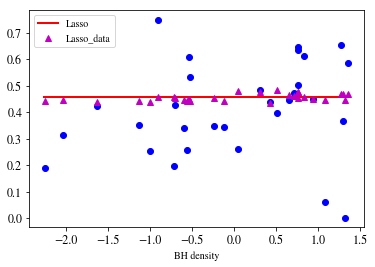

Baryonic fraction


Slope 0.0
Feature correlation 0.211227091306 



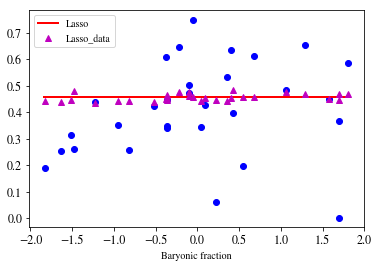

In [11]:
# We initialize Lasso at optimal alpha
lasso = Lasso(random_state=2305,alpha = alpha_optimal, max_iter=10000)

lasso.fit(X_boots,y_boots)
# Predicted by LASSO
y_data_lasso = lasso.predict(X) 


# Linspaces for each variable
linspcX = np.array([np.linspace(min(x)-0.01,max(x)+0.01,100) for x in X.T])

for i in range(len(Xnames)):
    # Names and slopes
    print( Xnames[i])
    print( '\n')
    print( 'Slope',lasso.coef_[i])
    #print( 'Feature Importance',rf.feature_importances_[i])
    print( 'Feature correlation',np.corrcoef(X[:,i],y1)[0,1],'\n')

    # Plot dataset projection over variable 
    plt.plot(X[:,i],y1,'bo')
    #plt.plot(badX[:,i],bady,'ro')

    # Given the multivariate model we can only use the mean in each other variable
    # All other variables mean are 0 given the normalization
    X_proj_mean = np.zeros((100,len(meanX)))
    X_proj_mean[:,i] = linspcX[i] # Except for the variable to study
    
    # Fit 
    yproj_lasso = lasso.predict(X_proj_mean)
     
    plt.plot(linspcX[i],yproj_lasso,'r',linewidth=2,label='Lasso') # Mean
    plt.plot(X[:,i],y_data_lasso,'m^',linewidth=2,label='Lasso_data') # Mean

    plt.legend(loc=0)

    plt.xlabel(Xnames[i])
    plt.show()
    plt.close()

## LASSO Final results


In [12]:
# order 
index_order = np.argsort(-lasso.coef_)
lista_feat = list(zip(lasso.coef_[index_order],[Xnames[i] for i in index_order]))
for i in range(len(lista_feat)):
    print(lista_feat[i])

(0.013821484574759877, 'Gas Radius')
(-0.0, 'StarDisk Radius')
(0.0, 'Gas density')
(0.0, 'Star density')
(0.0, 'BH density')
(0.0, 'Baryonic fraction')


## Random Forest
We use Random forest binary classifier. We declare the groups according to percentiles so that classes are balanced by construction. Random Forest naturally gives variable importances

But first...

## Parameters tunning
We use the bootstrapped X,y used before

In [13]:
# Labels for random forest
mid1 = np.percentile(y1,50)
#mid2 = np.percentile(y,66)
labels = (y1>mid1).astype(np.int)
labels_boots = (y_boots>mid1).astype(np.int)

from sklearn.ensemble import RandomForestClassifier

#random forest
rf = RandomForestClassifier(random_state=2305)

# The cross validation folds
n_folds = 3

# The parameters to tune
tuned_parameters = { 'n_estimators': [5,10,20,40,80],
                      'criterion' : ['gini','entropy'],
                      'min_samples_split' : [0.01,0.05,0.1],
                      'min_samples_leaf': [0.01,0.05,0.1]                     
                        }

# Grid search for lasso
clf = GridSearchCV(rf, tuned_parameters, cv=n_folds, refit=False, scoring = 'f1')
clf.fit(X_boots, labels_boots)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

## Best parameters

In [14]:
best_params = clf.cv_results_['params'][clf.best_index_]
clf.cv_results_['params'][clf.best_index_],'f1 score: {0}'.format(scores[clf.best_index_])

({'criterion': 'entropy',
  'min_samples_leaf': 0.01,
  'min_samples_split': 0.01,
  'n_estimators': 20},
 'f1 score: 0.9572649572649573')

## The model:

In [15]:
rf = RandomForestClassifier(random_state=2305,
                            criterion = best_params['criterion'],
                            min_samples_leaf = best_params['min_samples_leaf'],
                            min_samples_split = best_params['min_samples_split'],
                            n_estimators = best_params['n_estimators'], )

# fit
rf.fit(X_boots,labels_boots)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.01,
            min_samples_split=0.01, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=2305,
            verbose=0, warm_start=False)

## Random Forest Results

In [16]:
indices_imp = np.argsort(-rf.feature_importances_)
for i in range(len([Xnames[j] for j in indices_imp])):
    # Names and slopes
    print( [Xnames[j] for j in indices_imp][i])
    #print( '' )
    #print( 'Slope',lasso.coef_[i])
    print( 'Feature Importance',rf.feature_importances_[indices_imp][i])
    #print( 'Feature correlation',np.corrcoef((X.T[indices_imp].T)[:,i],y1[indices_imp])[0,1],'\n')
    print('')

Gas density
Feature Importance 0.224379572155

Gas Radius
Feature Importance 0.203937924127

BH density
Feature Importance 0.157899674591

StarDisk Radius
Feature Importance 0.155357722854

Baryonic fraction
Feature Importance 0.131003282238

Star density
Feature Importance 0.127421824036



## EMCEE
We use EMCEE to verify error intervals for a linear model to see if the output fit and the observed tendencies are conclusive and to clarify correlations

### Definitions

In [17]:
# Basic imports
import emcee

##########################
##### SETUP FUNCTIONS ####
##########################

# The model to fit parameters
# Asume linear model and power law for baryionic fraction
# Encode arguments of this function in theta
def model(theta,X):

    theta = np.array(theta)
    #print np.multiply(theta[:-1][:,np.newaxis],X)
    val = np.sum(np.multiply(theta[:-1][:,np.newaxis],X),axis=0)+ theta[-1]
    #print val
    return val

# Define the ln of the likelihood.
# Just assume exponential of the squared error
def lnlike(theta, X, y, yerr=1):

    y_mod = model(theta,X)
    inv_sigma2 = 1.0/(yerr**2) #+ model**2*np.exp(2*lnf))      -> This is more sophisticated
    return -0.5*(np.sum((y-y_mod)**2*inv_sigma2 - np.log(inv_sigma2)))

# The log of the prior probability
# All variables are free to choose (mainly slopes)
def lnprior(theta,X):

    #a0,a1,c = theta
    if False : # keep power term positive
        return -np.inf
    return 0 # no restrictions

# The log of the final probability of the model    
def lnprob(theta, X, y, yerr=1):
    lp = lnprior(theta,X)
    if not np.isfinite(lp): # Not needed but anyway jic
        return -np.inf
    return lp + lnlike(theta, X, y, yerr)


## The maximum likelihood

30 30


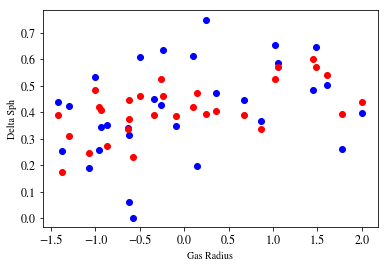

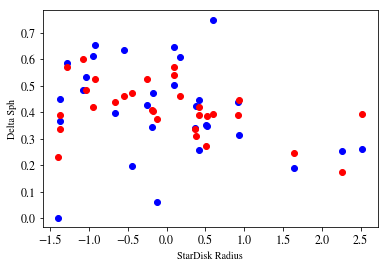

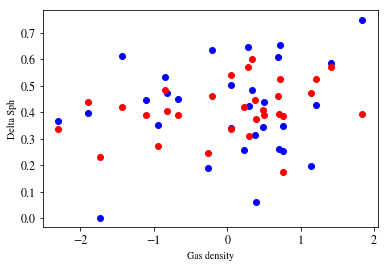

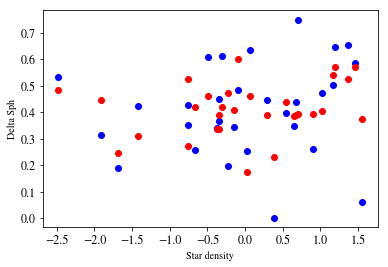

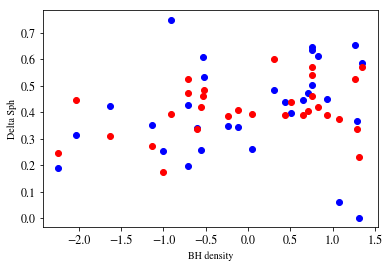

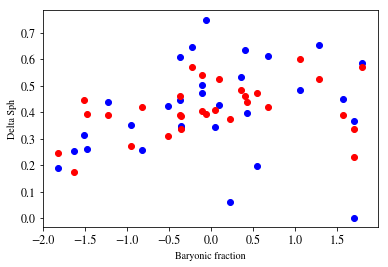

In [18]:
#print X.shape
X = X.T # To facilitate variable handling

# Now we find the maximum likelihood
import scipy.optimize as op
nll = lambda x,*t: model([t[i] for i in range(len(X)+1)],x)
print(len(X.T),len(y1))

popt,pcov = op.curve_fit(nll,X,y1,p0=0*np.ones(len(X)+1))

#scatter3d(X[-2], X[-1], y, y)    
yopt = model(popt,X)
xlabs = Xnames
for i in range(len(X)):
    plt.plot(X[i],y1,'bo')
    plt.plot(X[i],yopt,'ro')
    #plt.ylabel(r'$ \frac{a}{c}$')
    plt.ylabel('Delta Sph')
    plt.xlabel(xlabs[i])       
    #plt.savefig('./pics/Baryons_plots/'+xlabs[i]+'.png')
    plt.show()
    plt.close()


## The Random Walkers

In [19]:
# We initialize some walkers around the maximum likelihood
ndim, nwalkers = len(X)+1, 100
pos = [popt + (1e-6)*(1-2*np.random.randn(ndim)) for i in range(nwalkers)]

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(X, y1, 1.0))

# Run nwalks 
sampler.run_mcmc(pos, 1000)

# Retrieve chains after stabilization
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

## Results

((0.095578589072227188, 0.22626984517351253, 0.22017829166495045), 'Gas Radius')
((-0.18864825113494221, 0.56934686911894683, 0.5972265419682925), 'StarDisk Radius')
((0.10658551553609177, 0.26031200129804888, 0.24778838631382324), 'Gas density')
((-0.082256436799927335, 0.40798508337627276, 0.41099144566298373), 'Star density')
((0.091083861955715828, 0.51196984372962118, 0.48540539953440343), 'BH density')
((-0.18215770685747129, 0.59584952179449635, 0.63935919109539174), 'Baryonic fraction')
((0.41042438096532186, 0.17732557729326948, 0.17668469820819702), 'Intercept')


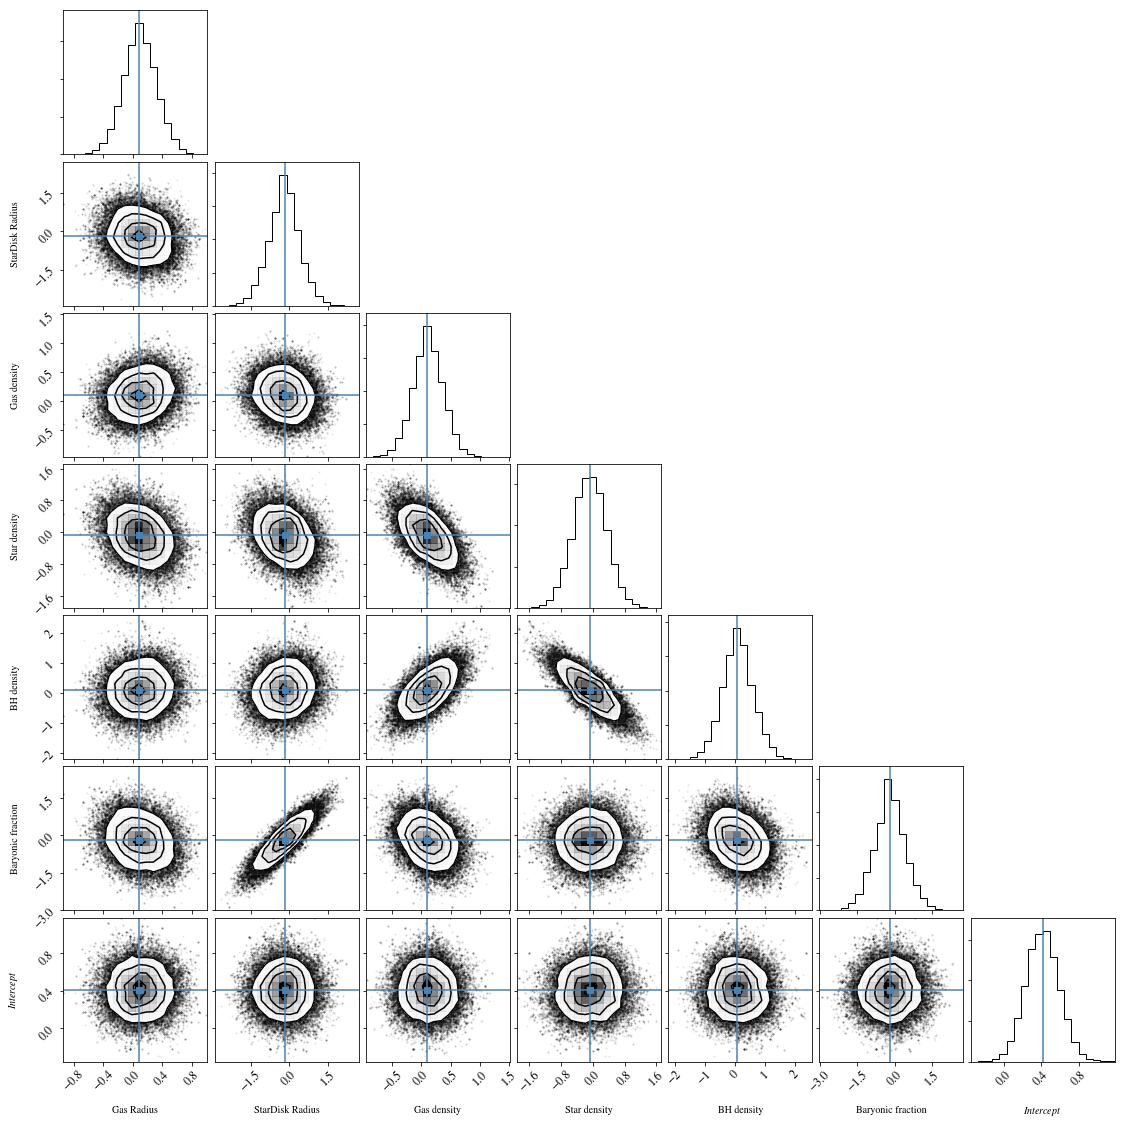

In [20]:
#print result
import corner    
fig = corner.corner(samples, labels= Xnames+['$Intercept$'], truths = popt)
results = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))

signal_noise = []
for el in zip(results,Xnames+['Intercept']):
    print(el)
    signal_noise.append(el[0][0]/(el[0][1]+el[0][2]))

    
    
plt.show()

## signal to noise ratio of slope for multilinear model

In [21]:
indices_stnr = np.argsort(-np.array(signal_noise))
for i in range(len(Xnames)+1):
    print([(Xnames+['Intercept'])[j] for j in indices_stnr][i],np.array(signal_noise)[indices_stnr][i])

Intercept 1.1593572542
Gas Radius 0.214086656849
Gas density 0.209772553091
BH density 0.0913235640957
Star density -0.10043808813
Baryonic fraction -0.147471196533
StarDisk Radius -0.16171142711
